# Wstęp do Uczenia Maszynowego - Lab 7

## Bias-Variance Tradeoff

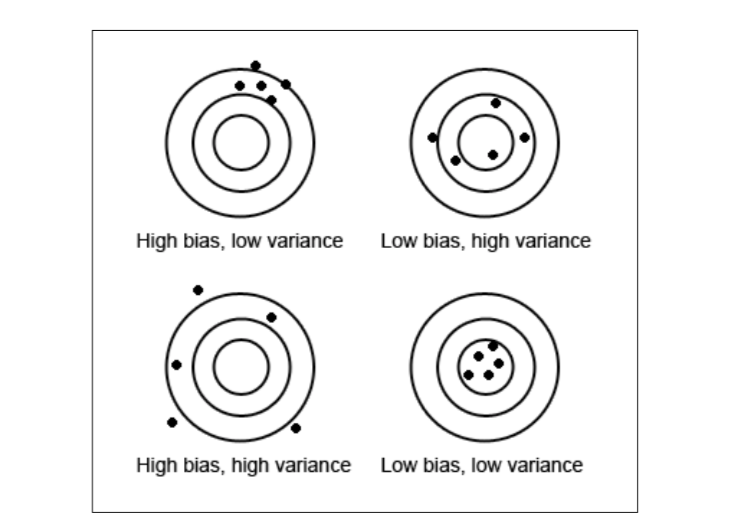

Gdzie mamy doczynienia z Overfittingiem a gdzie z Underfittingiem?

## Szukanie Hiperparametrów
Wczytujemy te same dane co ostatnio:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
np.random.seed(123) 

/home/kaketo/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
data=pd.read_csv('heart.csv')

In [3]:
y = np.array(data['chd'])
X = data.drop(['chd'],axis=1)

In [4]:
map_dict = {'Present': 1, 'Absent':0}
X['famhist'] = X['famhist'].map(map_dict)
X.head()

,sbp,tobacco,ldl,adiposity,famhist,typea,obesity,alcohol,age
0,160,12.00,5.73,23.11,1,49,25.30,97.20,52
1,144,0.01,4.41,28.61,0,55,28.87,2.06,63
2,118,0.08,3.48,32.28,1,52,29.14,3.81,46
3,170,7.50,6.41,38.03,1,51,31.99,24.26,58
4,134,13.60,3.50,27.78,1,60,25.99,57.34,49


### Podział na train, test
Przypomnienie czym się różni zbiór walidacyjny od testowego?

In [5]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test =train_test_split(X, y, test_size=0.2)

Drzewo decyzyjne - prosty model w którym będziemy stroić hiperparametry

In [6]:
from sklearn.tree import DecisionTreeClassifier
tree_model= DecisionTreeClassifier()

In [7]:
tree_model

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [8]:
tree_model.fit(X_train, y_train);

In [9]:
tree_model.score(X_test, y_test)

0.6344086021505376

### Rola cross-walidacji w strojeniu hiperparametrów

In [10]:
import sklearn
from sklearn.model_selection import cross_val_score
tree_model= DecisionTreeClassifier()
results=cross_val_score(tree_model, X, y, cv=5) # można zdefiniować: scoring='roc_auc'
# UWAGA: tutaj nie strojono parametrów więc można użyć całego zbioru!
print(np.mean(results), np.std(results))

0.6644693782141188 0.023197947221853043


### Jakie metryki chcemy maksymalizować?

In [11]:
sklearn.metrics.SCORERS.keys()

dict_keys(['explained_variance', 'r2', 'max_error', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_root_mean_squared_error', 'neg_mean_poisson_deviance', 'neg_mean_gamma_deviance', 'accuracy', 'roc_auc', 'roc_auc_ovr', 'roc_auc_ovo', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'neg_brier_score', 'adjusted_rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_weighted'])

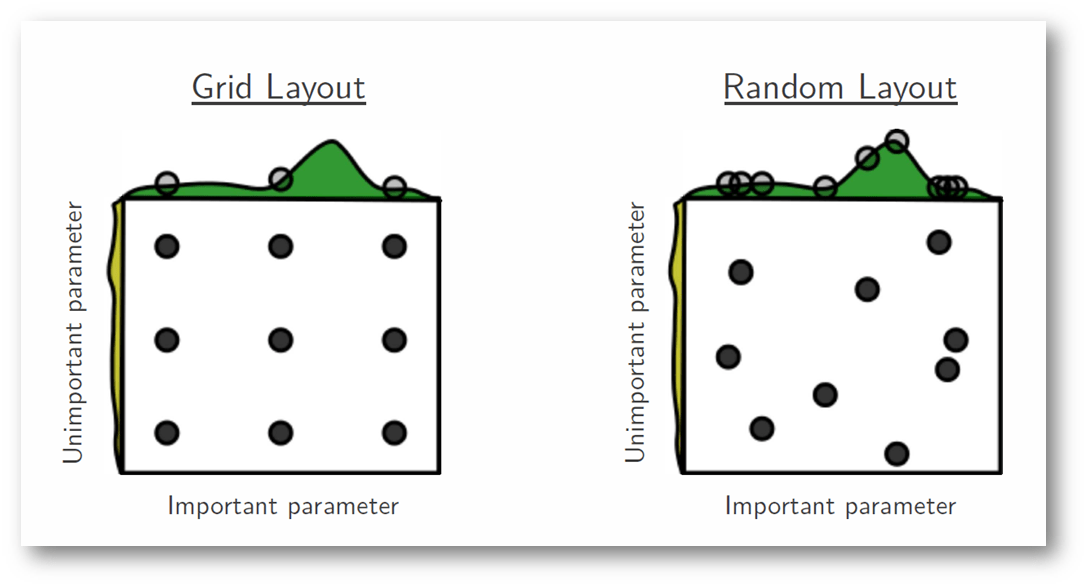

#### Dlaczego Random > Grid w więkoszości przypadków:
http://www.jmlr.org/papers/volume13/bergstra12a/bergstra12a.pdf

Kiedy jednak Grid będzie lepszy od Random?

### Grid Search

In [12]:
from sklearn.model_selection import GridSearchCV

In [13]:
max_depth=[3, 5, 6]
criterion=["gini","entropy"]
min_samples_split=[5,10,15]
param_grid = dict(max_depth=max_depth,criterion=criterion, min_samples_split=min_samples_split)

In [14]:
tree_model= DecisionTreeClassifier()
grid = GridSearchCV(estimator=tree_model, param_grid=param_grid, cv = 3, n_jobs=-1)

grid_result = grid.fit(X_train, y_train) #tutaj lepiej zastosować tylko trainset

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: 0.693767 using {'criterion': 'entropy', 'max_depth': 3, 'min_samples_split': 15}


In [15]:
mean_test_scores = grid_result.cv_results_['mean_score_time']
std_test_scores = grid_result.cv_results_['std_score_time']
mean_train_scores = grid_result.cv_results_['mean_fit_time']
#std_train_scores = grid_result.cv_results_['std_fit_time']
parameters = grid_result.cv_results_['params']

for mean_test, std_test, params in zip(mean_test_scores, std_test_scores, parameters):
    print('Parameters : {}'.format(params))
    print('Mean test score: {:.8f}'.format(mean_test))
    print('Standard Deviation (test) : {:.8f}'.format(std_test))
    print()

print('Best parameters : {}'.format(grid_result.best_params_))
print('Best accuracy score : {:.8f}'.format(grid_result.best_score_))


Parameters : {'criterion': 'gini', 'max_depth': 3, 'min_samples_split': 5}
Mean test score: 0.00145531
Standard Deviation (test) : 0.00014261

Parameters : {'criterion': 'gini', 'max_depth': 3, 'min_samples_split': 10}
Mean test score: 0.00147653
Standard Deviation (test) : 0.00003191

Parameters : {'criterion': 'gini', 'max_depth': 3, 'min_samples_split': 15}
Mean test score: 0.00147208
Standard Deviation (test) : 0.00016524

Parameters : {'criterion': 'gini', 'max_depth': 5, 'min_samples_split': 5}
Mean test score: 0.00131162
Standard Deviation (test) : 0.00021403

Parameters : {'criterion': 'gini', 'max_depth': 5, 'min_samples_split': 10}
Mean test score: 0.00184274
Standard Deviation (test) : 0.00057973

Parameters : {'criterion': 'gini', 'max_depth': 5, 'min_samples_split': 15}
Mean test score: 0.00147255
Standard Deviation (test) : 0.00009054

Parameters : {'criterion': 'gini', 'max_depth': 6, 'min_samples_split': 5}
Mean test score: 0.00143607
Standard Deviation (test) : 0.00004

In [16]:
best_model=grid_result.best_estimator_
best_model.score(X_test, y_test)

0.6559139784946236

przykład wizualizacji:
    https://scikit-learn.org/stable/auto_examples/model_selection/plot_multi_metric_evaluation.html

### Random Search 

In [17]:
from sklearn.model_selection import RandomizedSearchCV

In [18]:
random = RandomizedSearchCV(estimator=tree_model, param_distributions=param_grid, cv = 3, n_jobs=-1)

random_result = random.fit(X_train, y_train)
# Summarize results
print("Best: %f using %s" % (random_result.best_score_, random_result.best_params_))

Best: 0.693767 using {'min_samples_split': 15, 'max_depth': 3, 'criterion': 'entropy'}


In [19]:
best_model=random_result.best_estimator_
best_model.score(X_test, y_test)

0.6559139784946236

- Zdefiniowanie rozkładów

In [20]:
from scipy.stats import poisson,randint
param_grid = {'min_samples_split': randint(5,50),
             'max_depth': poisson(5)}

In [21]:
random = RandomizedSearchCV(estimator=tree_model, param_distributions=param_grid, cv = 3, n_jobs=-1, random_state=123)

random_result = random.fit(X_train, y_train)
# Summarize results
print("Best: %f using %s" % (random_result.best_score_, random_result.best_params_))

Best: 0.680217 using {'max_depth': 3, 'min_samples_split': 5}


https://ksopyla.com/machine-learning/grid-random-search-scikit-learn-dobor-parametrow/

## Bayes optimization

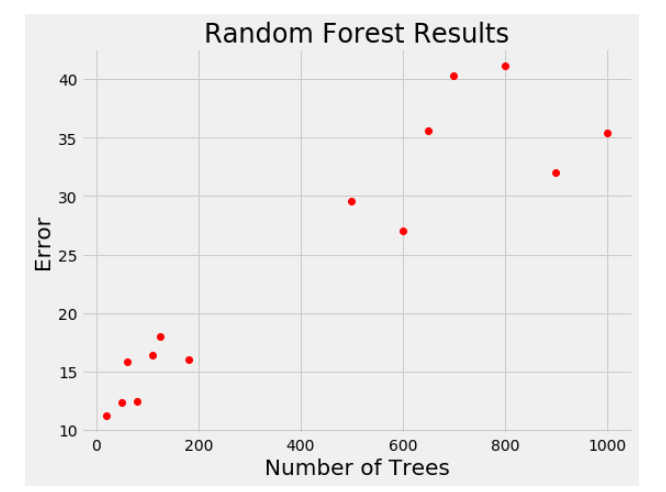

### W którym miejscu będziemy szukać następnej wartości parametru n_trees?

In [22]:
# !pip install scikit-optimize

In [23]:
from skopt import BayesSearchCV
from sklearn.svm import SVC

# log-uniform: understand as search over p = exp(x) by varying x
opt = BayesSearchCV(
    SVC(),
    {
        'C': (1e-6, 1e+6, 'log-uniform'),
        'gamma': (1e-6, 1e+1, 'log-uniform'),
        'degree': (1, 8),  # integer valued parameter
        'kernel': ['linear', 'poly', 'rbf'],  # categorical parameter
    },
    n_iter=2,
    cv=3
)

opt.fit(X_train, y_train)

print("val. score: %s" % opt.best_score_)
print("test score: %s" % opt.score(X_test, y_test))

val. score: 0.6558265582655827
test score: 0.6451612903225806


https://scikit-optimize.github.io/stable/auto_examples/sklearn-gridsearchcv-replacement.html

## Selekcja zmiennych

### Filtry
Najprostsze metody, można z nich korzystać nie wykorzystując nawet modeli. Można wykonać ten krok na etapie preprocessingu danych.

**Przykłady:**
- korelacja ze zmienną celu
- informacja wzajema ze zmienną celu

In [24]:
X_y = X.copy()
X_y['Target'] = y

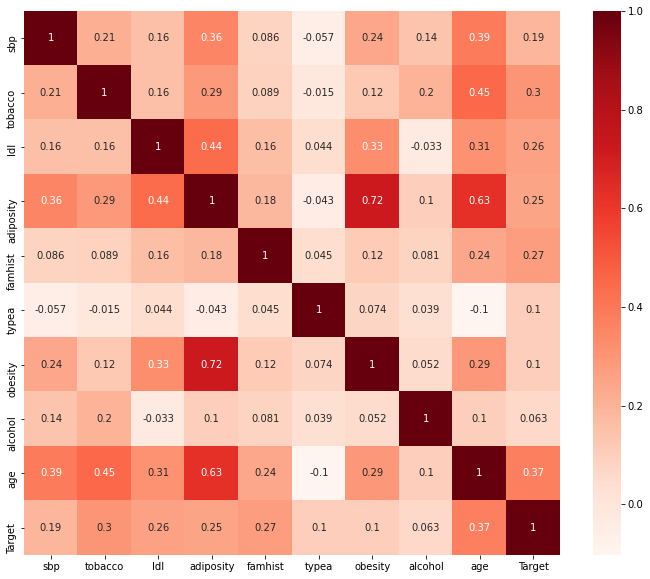

In [25]:
plt.figure(figsize=(12,10))
cor = X_y.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

### Metody wbudowane
Niektóre metody mają wbudowane metody *feature importance*, np. Random Forest albo regresja Lasso.

https://towardsdatascience.com/the-mathematics-of-decision-trees-random-forest-and-feature-importance-in-scikit-learn-and-spark-f2861df67e3

In [26]:
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
import matplotlib.pyplot as plt
rf = RandomForestClassifier(n_jobs=-1, class_weight='balanced', max_depth=5)
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=5, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

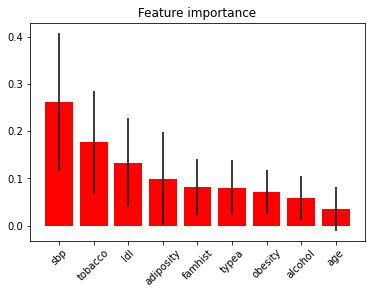

In [27]:
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]


plt.figure()
plt.title("Feature importance")
plt.bar(X.columns, importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(rotation=45)
plt.show()

### Wrappery
Oceniają poszczególne zbiory parametrów na podstawie wybranych metryk (accuracy, AUC, ...). Zazwyczaj działa to w ten sposób, że iteracyjnie dodajemy/odejmujemy kolejne parametry aż osiągniemy daną liczbę parametrów/wynik modelu.

**Przykłady:**
- Recursive Feature Elimination
- Forward Selection
- Boruta

#### Recursive Feature Elimination
1. Uczymy model na wszystkich zmiennych
2. Iteracyjnie usuwamy kolejne zmienne, które mają najmniejszy importance (atrybut: feature_importances_)
3. Powtarzamy 1 i 2 aż osiągniemy określoną liczbę zmiennych

In [28]:
from sklearn.feature_selection import RFE
estimator = tree_model
selector = RFE(estimator, n_features_to_select=3, step=1)
selector = selector.fit(X_train, y_train) 

In [29]:
print(selector.support_)
selector.ranking_

[False False  True False False False  True False  True]


array([4, 2, 1, 6, 7, 3, 1, 5, 1])

In [30]:
# tree_model.feature_importances_

## AUTO_ML
Istnieje dużo gotowych narzędzi np. TPOT, auto-sklearn, ...

In [31]:
# ! pip install tpot

In [32]:
from tpot import TPOTClassifier
#from tpot import TPOTRegressor

tpot = TPOTClassifier(generations=5,verbosity=2)

tpot.fit(X_train, y_train)

Generation 1 - Current best internal CV score: 0.7264346538319142
Generation 2 - Current best internal CV score: 0.7426508700481304
Generation 3 - Current best internal CV score: 0.7426508700481304
Generation 4 - Current best internal CV score: 0.7426508700481304
Generation 5 - Current best internal CV score: 0.7426508700481304

Best pipeline: LinearSVC(input_matrix, C=5.0, dual=False, loss=squared_hinge, penalty=l1, tol=0.1)


TPOTClassifier(config_dict=None, crossover_rate=0.1, cv=5,
               disable_update_check=False, early_stop=None, generations=5,
               max_eval_time_mins=5, max_time_mins=None, memory=None,
               mutation_rate=0.9, n_jobs=1, offspring_size=None,
               periodic_checkpoint_folder=None, population_size=100,
               random_state=None, scoring=None, subsample=1.0, template=None,
               use_dask=False, verbosity=2, warm_start=False)

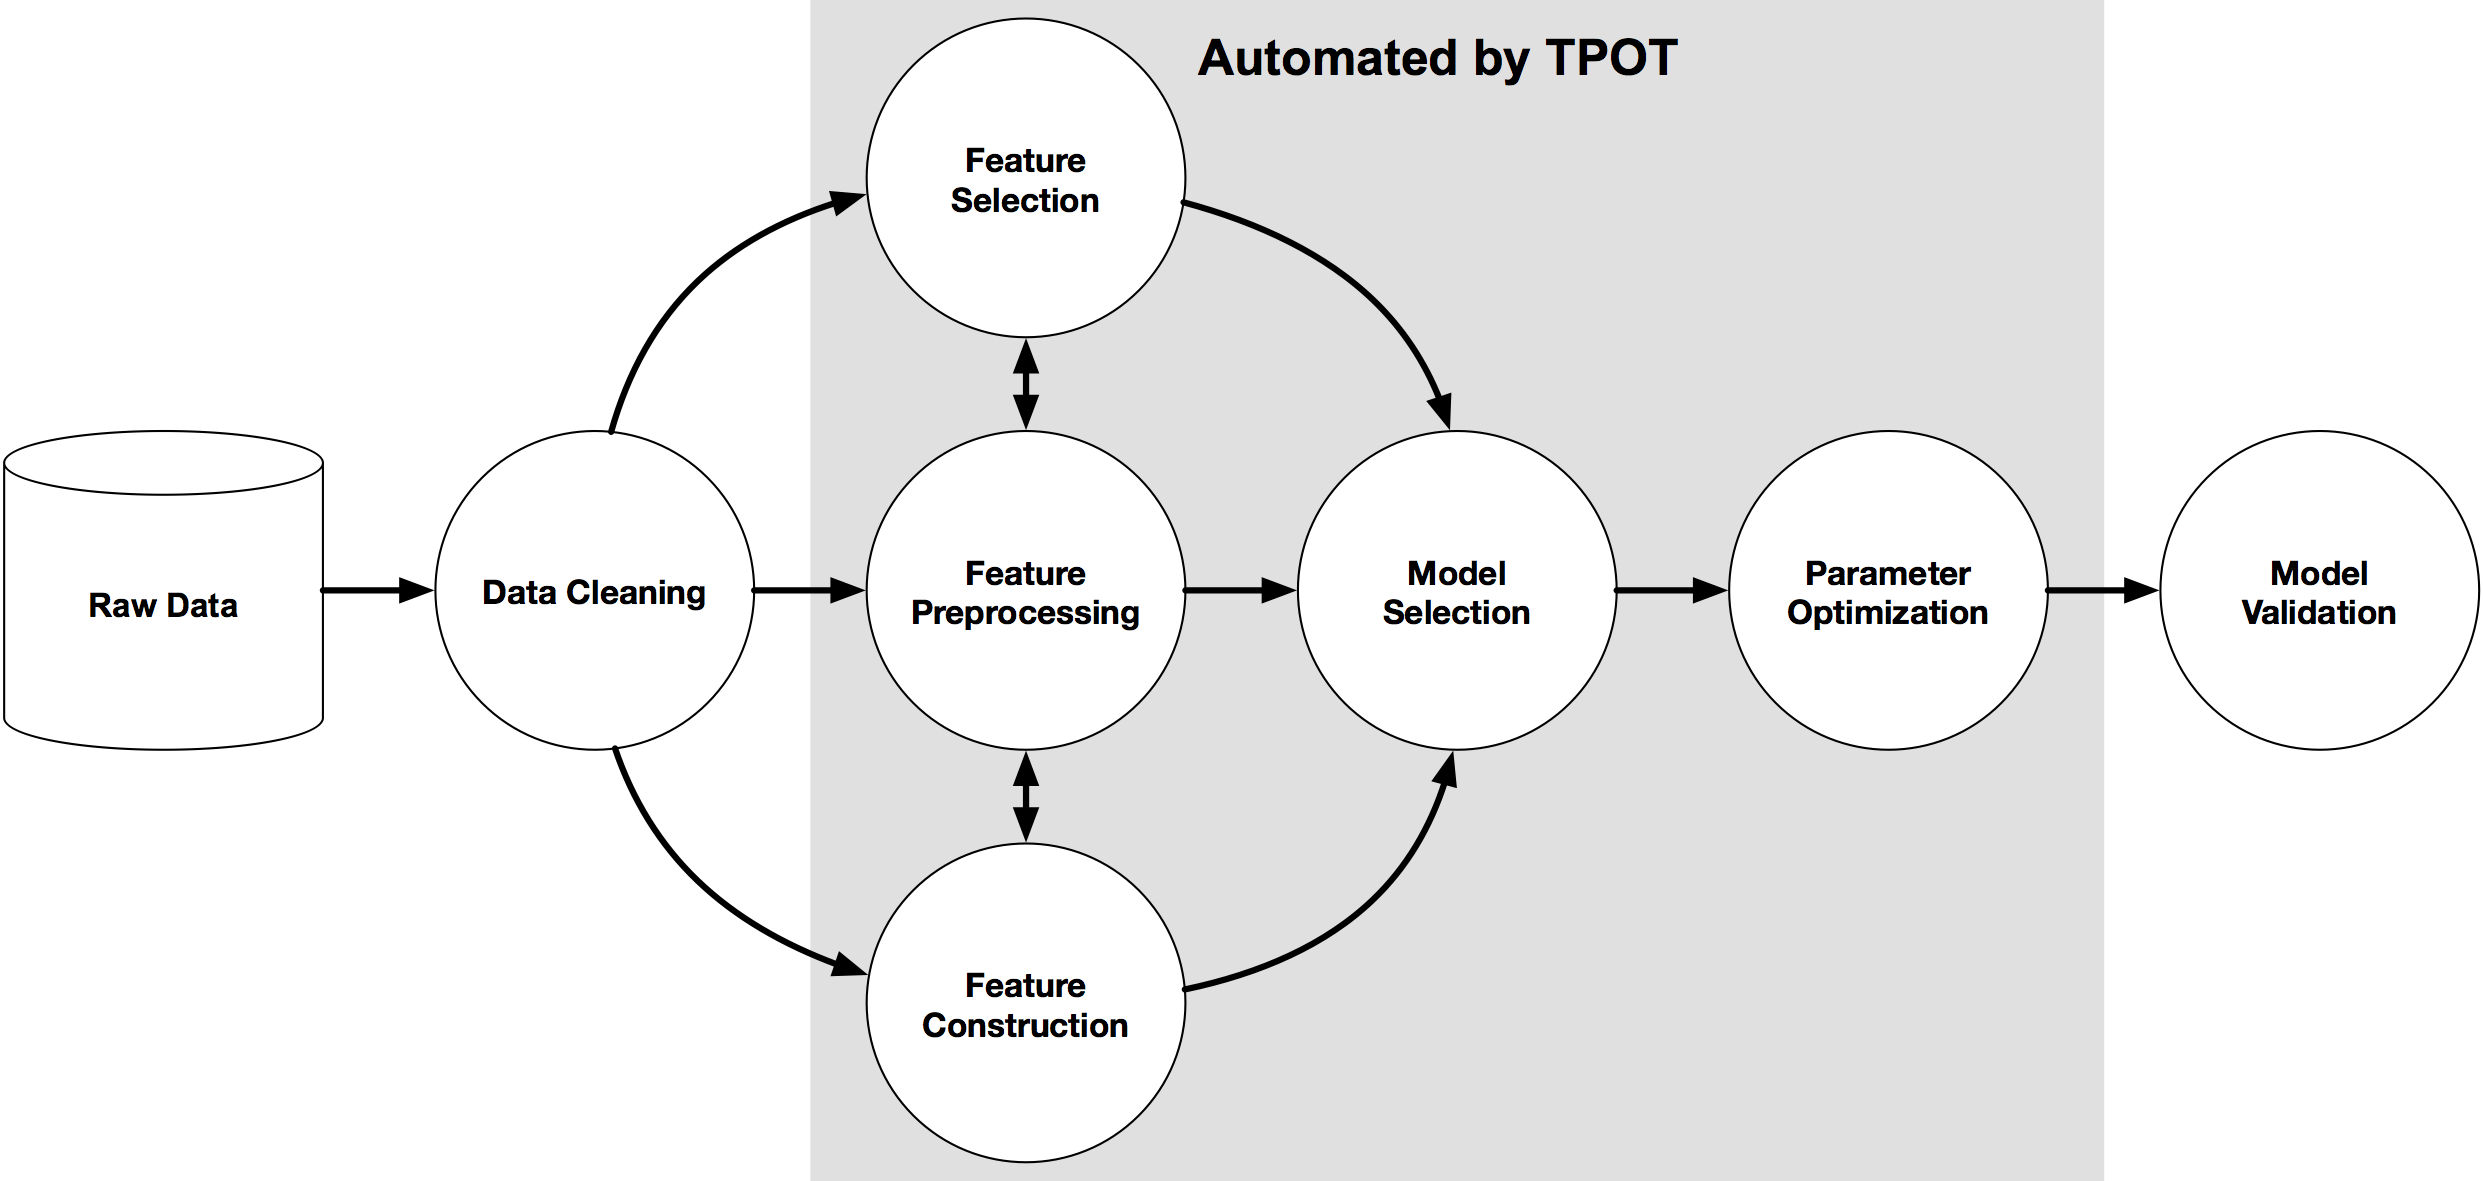

In [33]:
tpot.score(X_test, y_test)

0.7311827956989247

## XAI

### Ceterus Paribus
https://pbiecek.github.io/ema/ceterisParibus.html

In [34]:
from sklearn.tree import DecisionTreeClassifier
tree_model= DecisionTreeClassifier()
tree_model.fit(X_train, y_train);

In [35]:
X_test.head()

,sbp,tobacco,ldl,adiposity,famhist,typea,obesity,alcohol,age
49,126,3.80,3.88,31.79,0,57,30.53,0.00,30
85,130,0.56,3.30,30.86,0,49,27.52,33.33,45
34,148,5.50,7.10,25.31,0,56,29.84,3.60,48
231,136,13.20,7.18,35.95,0,48,29.19,0.00,62
236,126,5.50,3.78,34.15,0,55,28.85,3.18,61


In [36]:
from ceteris_paribus.explainer import explain

explainer_tree = explain(tree_model, data=X, y=y, label='TreeClassifier',
    predict_function=lambda X: tree_model.predict_proba(X)[::, 1])

In [37]:
obs = X_test.iloc[2,:]
obs_label = y_test[2]

In [38]:
from ceteris_paribus.profiles import individual_variable_profile
cp_tree = individual_variable_profile(explainer_tree, obs, obs_label)

In [39]:
from ceteris_paribus.plots.plots import plot
plot(cp_tree, selected_variables=['age','tobacco','alcohol','obesity'])

Zobaczmy teraz bardziej złożony klasyfikator

In [40]:
from xgboost import XGBClassifier
xgb_model= XGBClassifier()
xgb_model.fit(X_train, y_train);

In [41]:
explainer_xgb = explain(xgb_model, data=X, y=y, label='XGBoost',
    predict_function=lambda X: xgb_model.predict_proba(X)[::, 1])
cp_xgb = individual_variable_profile(explainer_xgb, obs, obs_label)
plot(cp_xgb, selected_variables=['age','tobacco','alcohol','obesity'])

### PD - plot
https://pbiecek.github.io/ema/partialDependenceProfiles.html

Uśredniony Ceterus Paribus dla wszystkich obserwacji - zachęcam do własnej implementacji

### SHAP
https://github.com/slundberg/shap